In [1]:
%%capture
import scikits.samplerate
import sklearn
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2
import logging
import theano.tensor as T
import lasagne
import logging
log = logging.getLogger()
log.setLevel("DEBUG")
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'png' 

import matplotlib.lines as mlines
import seaborn
seaborn.set_style('darkgrid')
matplotlib.rcParams['figure.figsize'] = (16.0, 1.0)
matplotlib.rcParams['font.size'] = 7
from braindecode.scripts.print_results import ResultPrinter
import theano
import scipy.signal
import numpy as np
from braindecode.veganlasagne.layer_util import print_layers
from braindecode.results.results import ResultPool

In [2]:
from braindecode.experiments.load import load_exp_and_model

In [3]:
ResultPrinter('data/models/paper/ours/cnt/deep4/').print_results(sets=True,
    params=dict(resample_fs=250, layers='$deep_5',
                cnt_preprocessors='$resample_highpass_standardize',
               low_cut_off_hz='null', layer_names_to_norms='$layer_names_to_norms',
               loss_expression='$tied_neighbours',
               first_nonlin='$elu',
               filter_length_3=10,
               split_first_layer=True,
               batch_norm=True,
               drop_prob=0.5))

Printing results in data/models/paper/ours/cnt/deep4/:

Terminal Table

id    filename  max_min  1st_pool_layer  rejection_var_ival  num_split_folds  misclass_monitor   whisker_percent  test_filename  whisker_length  eog_sensors       pool_layers  i_test_fold  rejection_blink_ival  batch_modifier  time     test    test_sample  best     epoch  train    valid    
3122  AnWe1-12  600      Pool            [0, 4000]           10               $default_misclass  10               AnWe1-2        3               ['EOGv', 'EOGh']  Pool         -1           [-500, 4000]          -               1:21:42  73.75%  70.12%       78.75%   337    100.00%  100.00%  
3124  BhNo1-12  600      Pool            [0, 4000]           10               $default_misclass  10               BhNo1-2        3               ['EOGv', 'EOGh']  Pool         -1           [-500, 4000]          -               0:31:42  98.75%  98.50%       100.00%   53    100.00%  100.00%  
3130  FaMa1-14  600      Pool            [0, 4000]  

In [8]:
from braindecode.mywyrm.plot import ax_scalp
from braindecode.analysis.plot_util import plot_chan_matrices

In [16]:
from braindecode.datasets.sensor_positions import get_EEG_sensors_sorted

In [17]:
freqs = np.fft.rfftfreq(n=1000,d=1.0/250.0)

In [18]:
res_pool = ResultPool()
res_pool.load_results('data/models/paper/ours/cnt/deep4/car/',
                      params=dict(sensor_names="$all_EEG_sensors", batch_modifier="null",
                         low_cut_off_hz="null", first_nonlin="$elu"))
result_file_names = res_pool.result_file_names()
results = res_pool.result_objects()

# sort by dataset filename
sort_order = np.argsort([r.parameters['dataset_filename'] for r in results])

result_file_names = np.array(result_file_names)[sort_order]
results = np.array(results)[sort_order]

unclean_sets = ['AnWe', 'OlIl', 'SvMu']


all_base_names = [name.replace('.result.pkl', '')
    for name in result_file_names]
clean_mask = []
all_corrs = dict()
for i_file, base_name in enumerate(all_base_names):
    if any(s in results[i_file].parameters['dataset_filename'] for s in unclean_sets):
        clean_mask.append(False)
    else:
        clean_mask.append(True)
    for perturb_name in ('rand_mad', 'rand_std', 'shuffle'):
        file_name = base_name + '.{:s}.amp_corrs.npy'.format(perturb_name)
        assert os.path.isfile(file_name)
        this_arr = all_corrs.pop(perturb_name, [])
        this_arr.append(np.load(file_name))
        all_corrs[perturb_name] = this_arr
        
clean_mask = np.array(clean_mask)

### All frequency bands on same scale

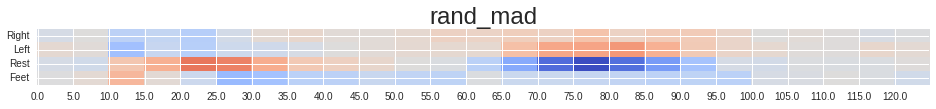

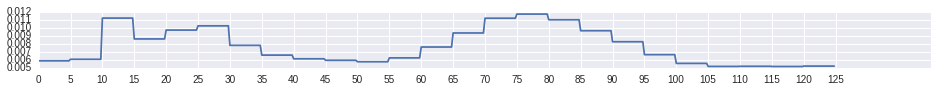

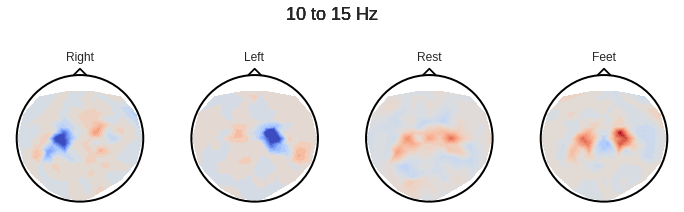

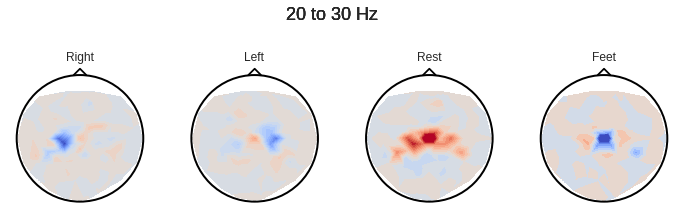

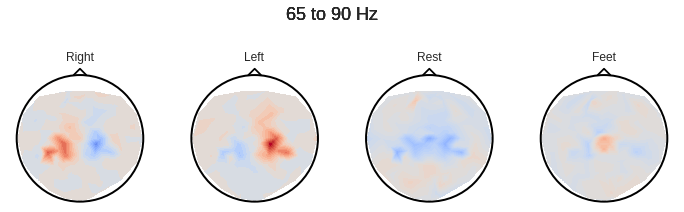

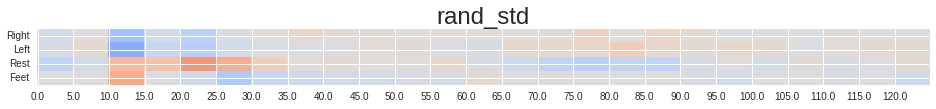

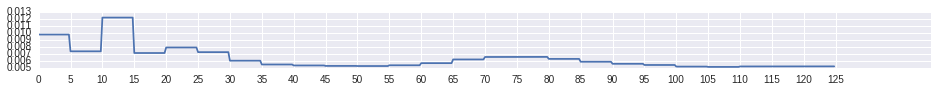

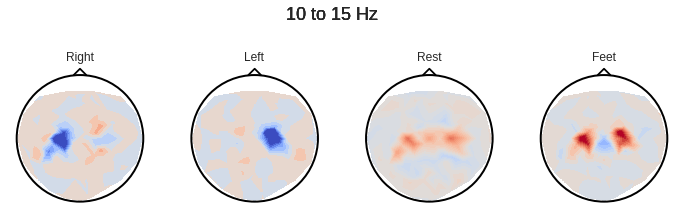

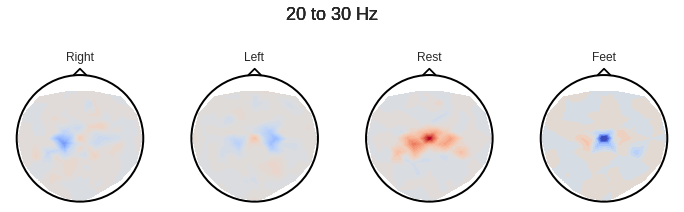

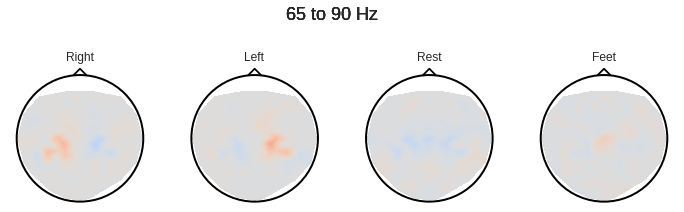

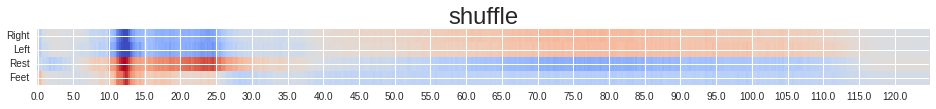

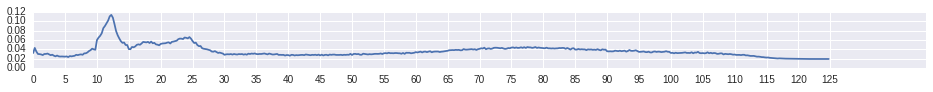

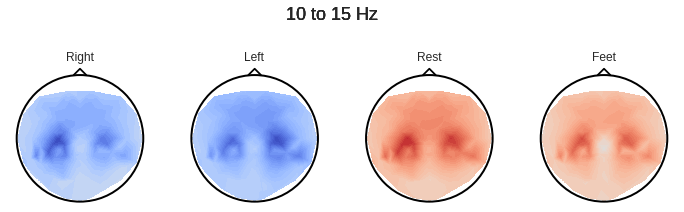

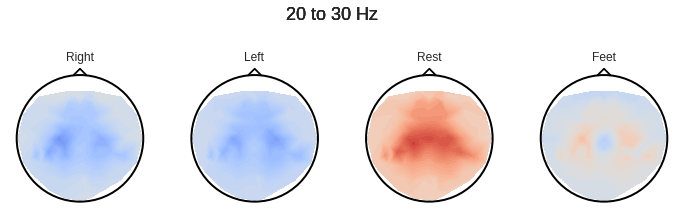

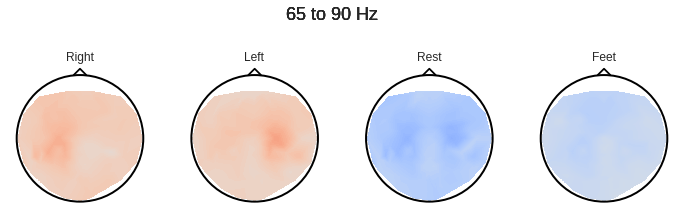

In [20]:
for corr_name in sorted(all_corrs.keys()):
    corrs = all_corrs[corr_name]
    corrs = np.array(corrs)[clean_mask]
    plt.figure()
    if 'rand' in corr_name:
        vmin, vmax = -0.005, 0.005
    else:
        vmin,vmax = -0.1, 0.1
    plt.imshow(np.mean(corrs, axis=(0,3)), cmap=cm.coolwarm, interpolation='nearest',
              aspect='auto', vmin=vmin, vmax=vmax)
    plt.xticks(range(500)[::20], freqs[::20])
    plt.yticks(range(4), ('Right', 'Left', 'Rest', 'Feet'))
    plt.title(corr_name, fontsize=24)
    None

    plt.figure()
    plt.plot(freqs[:-1], np.mean(np.abs(corrs), axis=(0,1,3)).T)
    plt.xticks(range(0,130,5))
    None

    if 'rand' in corr_name:
        vmin, vmax = -0.05, 0.05
    else:
        vmin,vmax = -0.15, 0.15
    for freq_low, freq_high in ((10,15), (20,30), (65,90)):
        i_freq_start = freqs.tolist().index(freq_low)
        i_freq_stop = freqs.tolist().index(freq_high) + 1
        fig = plt.figure(figsize=(12,4))
        for i_class, class_name in zip(range(4), ('Right', 'Left', 'Rest', 'Feet')):
            ax = plt.subplot(1,4,i_class+1)
            ax_scalp(np.mean(corrs[:,i_class,i_freq_start:i_freq_stop], axis=(0,1)),
                     get_EEG_sensors_sorted(), colormap=cm.coolwarm, ax=ax,
                    vmin=vmin, vmax=vmax)
            ax.set_title(class_name)
            fig.suptitle("{:d} to {:d} Hz".format(freq_low, freq_high), y=0.96, fontsize=18)


### Individually scaled

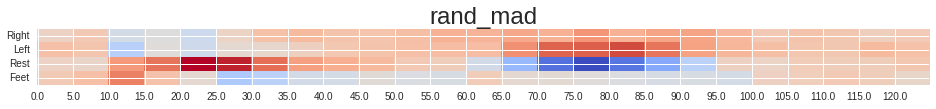

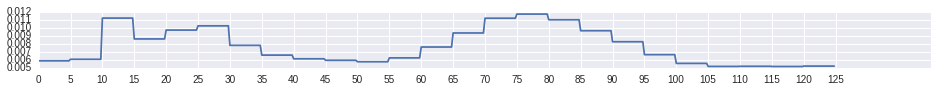

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


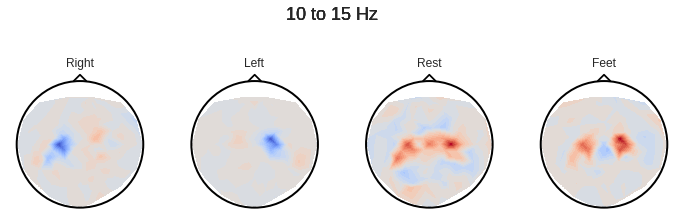

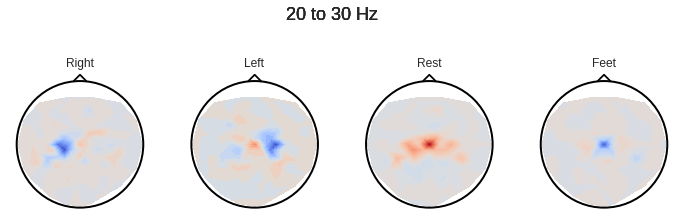

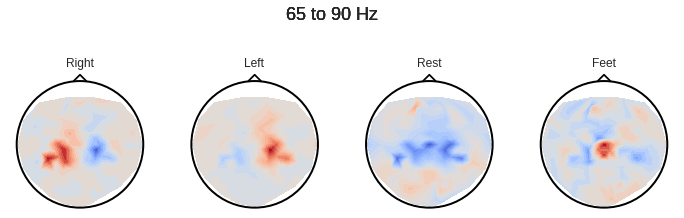

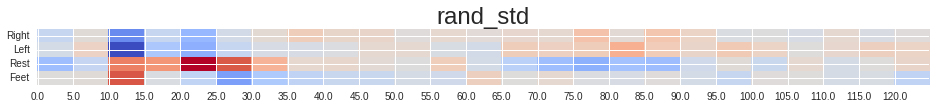

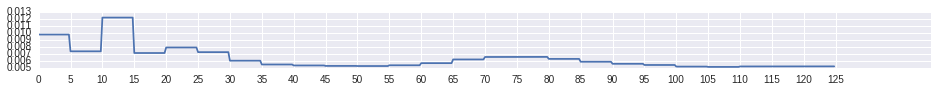

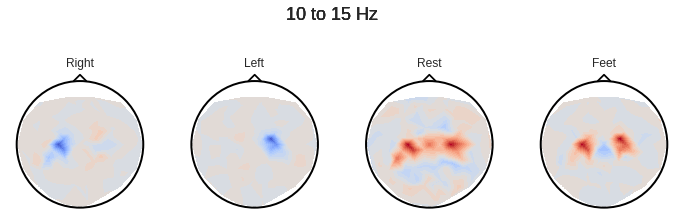

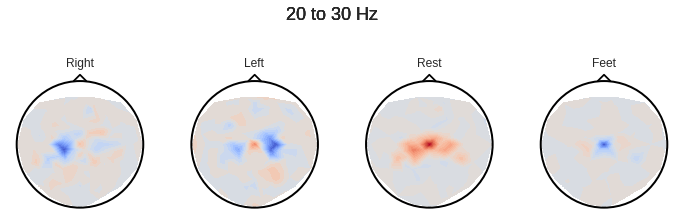

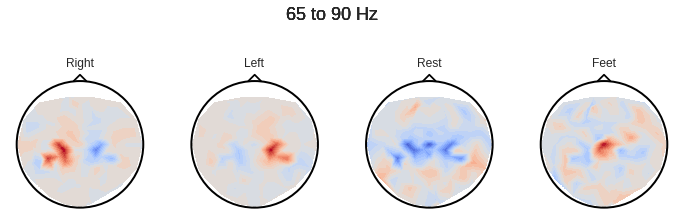

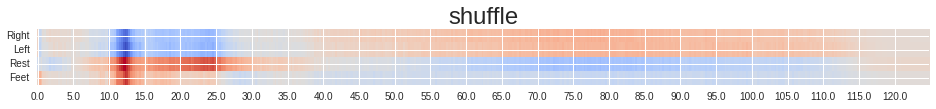

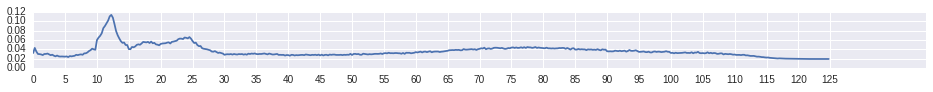

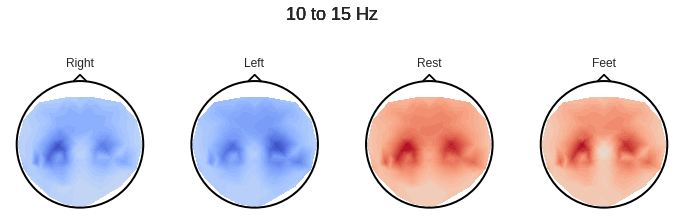

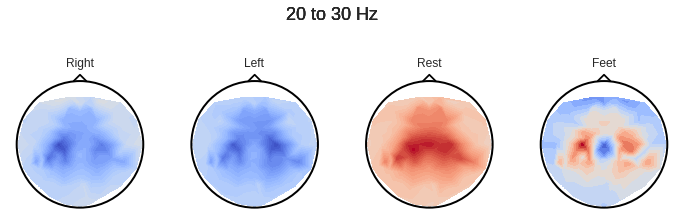

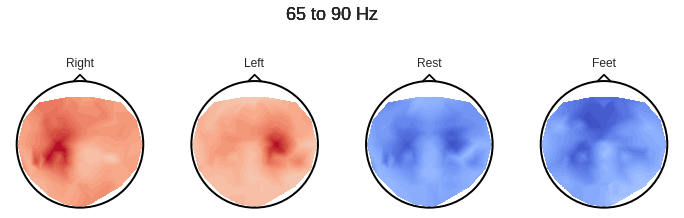

In [19]:
for corr_name in sorted(all_corrs.keys()):
    corrs = all_corrs[corr_name]
    corrs = np.array(corrs)[clean_mask]
    plt.figure()
    plt.imshow(np.mean(corrs, axis=(0,3)), cmap=cm.coolwarm, interpolation='nearest',
              aspect='auto')
    plt.xticks(range(500)[::20], freqs[::20])
    plt.yticks(range(4), ('Right', 'Left', 'Rest', 'Feet'))
    plt.title(corr_name, fontsize=24)
    None

    plt.figure()
    plt.plot(freqs[:-1], np.mean(np.abs(corrs), axis=(0,1,3)).T)
    plt.xticks(range(0,130,5))
    None

    for freq_low, freq_high in ((10,15), (20,30), (65,90)):
        i_freq_start = freqs.tolist().index(freq_low)
        i_freq_stop = freqs.tolist().index(freq_high) + 1
        fig = plt.figure(figsize=(12,4))
        for i_class, class_name in zip(range(4), ('Right', 'Left', 'Rest', 'Feet')):
            ax = plt.subplot(1,4,i_class+1)
            ax_scalp(np.mean(corrs[:,i_class,i_freq_start:i_freq_stop], axis=(0,1)),
                     get_EEG_sensors_sorted(), colormap=cm.coolwarm, ax=ax)
            ax.set_title(class_name)
            fig.suptitle("{:d} to {:d} Hz".format(freq_low, freq_high), y=0.98, fontsize=18)
